# SFig — CEEMDAN Parameter Dependency (2–3 Stations)

Explores sensitivity to CEEMDAN parameters on monthly L2 tide series:
- extrema_detection: ['parabol', 'simple']
- trials (ensemble size): [128, 256, 512, 1024, 2048]
- epsilon: [0.1, 0.5, 1.0]

Metrics per run include IMF_0 standard deviation, reconstruction RMSE, number of IMFs, and slope of the last IMF (cm/yr). Figures and CSVs are saved under `Output/`.

In [8]:
# Imports & config
import os
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm

DATA_DIR = Path('Data')
MID_DIR = Path('Data_mid')
OUTPUT_DIR = Path('Output')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

np.random.seed(42)

try:
    from PyEMD import CEEMDAN
except Exception as e:
    print('PyEMD not found. Install with: pip install EMD-signal')
    raise


In [9]:
# Data loader
def load_monthly_txt(path: Path) -> pd.DataFrame:
    rows = []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        for ln in f:
            ln = ln.strip()
            if not ln:
                continue
            parts = ln.split()
            try:
                y, mo, d, hh, mm = map(int, parts[:5])
                val = float(parts[-1])
            except Exception:
                continue
            rows.append((datetime(y, mo, d, hh, mm), val))
    df = pd.DataFrame(rows, columns=['date', 'value']).sort_values('date').reset_index(drop=True)
    return df

def pick_stations(k=3):
    files = sorted(DATA_DIR.glob('Monthly_*.txt'))
    names = [p.stem.replace('Monthly_', '') for p in files]
    # prefer common stations if present
    preferred = ['Jeju','Busan','Incheon','Gunsan','Mokpo','Sokcho']
    chosen = [s for s in preferred if s in names][:k]
    if len(chosen) < k:
        for n in names:
            if n not in chosen:
                chosen.append(n)
                if len(chosen) == k:
                    break
    paths = [DATA_DIR / f'Monthly_{s}.txt' for s in chosen]
    return list(zip(chosen, paths))


In [10]:
# CEEMDAN runner + metrics
def run_ceemdan(values: np.ndarray, extrema_detection: str, trials: int, epsilon: float):
    ce = CEEMDAN(trials=trials, epsilon=epsilon)
    ce.EMD.extrema_detection = extrema_detection
    eIMFs = ce.ceemdan(values)
    return eIMFs

def compute_metrics(dates, signal, eIMFs):
    # eIMFs shape: (n_imf, n_samples)
    n_imf = int(eIMFs.shape[0])
    # Reconstruction uses sum of IMFs (CEEMDAN may exclude residue depending on version)
    recon = eIMFs.sum(axis=0)
    rmse_recon = float(np.sqrt(np.mean((signal - recon)**2)))
    imf0_std = float(np.nanstd(eIMFs[0])) if n_imf >= 1 else np.nan
    imf1_std = float(np.nanstd(eIMFs[1])) if n_imf >= 2 else np.nan
    # Slope (cm/yr) of last IMF
    x = mdates.date2num(pd.to_datetime(dates))
    last = eIMFs[-1] if n_imf >= 1 else np.zeros_like(signal)
    c = np.polyfit(x, last, deg=1) if len(x) > 1 else [np.nan, np.nan]
    yhat = np.poly1d(c)(x) if len(x) > 1 else np.full_like(signal, np.nan)
    years = (pd.to_datetime(dates).iloc[-1] - pd.to_datetime(dates).iloc[0]).days / 365.0 if len(x) > 1 else np.nan
    slope_last_cm_per_yr = float((yhat[-1] - yhat[0]) / years) if years and years > 0 else np.nan
    return {
        'n_imfs': n_imf,
        'rmse_recon': rmse_recon,
        'imf0_std': imf0_std,
        'imf1_std': imf1_std,
        'slope_last_cm_per_yr': slope_last_cm_per_yr
    }


In [18]:
# Sweep definitions (adjust as needed)
extrema_opts = ['parabol', 'simple']
trials_list = [128, 256, 512, 1024, 2048]
epsilons = [0.1, 0.25, 0.5, 0.75, 1.0]

stations = pick_stations(k=3)
stations


[('Jeju', PosixPath('Data/Monthly_Jeju.txt')),
 ('Busan', PosixPath('Data/Monthly_Busan.txt')),
 ('Incheon', PosixPath('Data/Monthly_Incheon.txt'))]

In [19]:
# Run sweep and collect metrics
all_results = {}
for station, path in stations:
    df = load_monthly_txt(path)
    s = df['value'].values.astype(float)
    t = df['date']
    rows = []
    for ext in extrema_opts:
        for tr in trials_list:
            for eps in epsilons:
                try:
                    eimfs = run_ceemdan(s, ext, tr, eps)
                    m = compute_metrics(t, s, eimfs)
                except Exception as e:
                    m = {k: np.nan for k in ['n_imfs','rmse_recon','imf0_std','imf1_std','slope_last_cm_per_yr']}
                m.update({'station': station, 'extrema': ext, 'trials': tr, 'epsilon': eps})
                rows.append(m)
    res = pd.DataFrame(rows)
    all_results[station] = res
    out_csv = OUTPUT_DIR / f'SFig_param_sweep_{station}.csv'
    res.to_csv(out_csv, index=False)
    print('Saved', out_csv)
len(all_results)


Saved Output/SFig_param_sweep_Jeju.csv
Saved Output/SFig_param_sweep_Busan.csv
Saved Output/SFig_param_sweep_Incheon.csv


3

In [12]:
# Plot trends per station: epsilon & trials
for station, df in all_results.items():
    # 1) IMF_0 std vs epsilon for each trials, per extrema
    for ext in df['extrema'].dropna().unique():
        _d = df[df['extrema']==ext]
        fig, ax = plt.subplots(1,1,figsize=(6,4))
        for tr in sorted(_d['trials'].dropna().unique()):
            d2 = _d[_d['trials']==tr].sort_values('epsilon')
            ax.plot(d2['epsilon'], d2['imf0_std'], marker='o', label=f'trials={int(tr)}')
        ax.set_title(f'{station} — IMF0 std vs epsilon (extrema={ext})')
        ax.set_xlabel('epsilon')
        ax.set_ylabel('IMF0 std')
        ax.grid(True, ls=':')
        ax.legend()
        fig.tight_layout()
        fig.savefig(OUTPUT_DIR / f'SFig_param_{station}_imf0std_vs_epsilon_{ext}.pdf', dpi=400, bbox_inches='tight')
        plt.close(fig)

    # 2) RMSE recon vs trials for each epsilon, per extrema
    for ext in df['extrema'].dropna().unique():
        _d = df[df['extrema']==ext]
        fig, ax = plt.subplots(1,1,figsize=(6,4))
        for eps in sorted(_d['epsilon'].dropna().unique()):
            d2 = _d[_d['epsilon']==eps].sort_values('trials')
            ax.plot(d2['trials'], d2['rmse_recon'], marker='o', label=f'epsilon={eps}')
        ax.set_title(f'{station} — Recon RMSE vs trials (extrema={ext})')
        ax.set_xlabel('trials (ensemble size)')
        ax.set_ylabel('RMSE of reconstruction')
        ax.grid(True, ls=':')
        ax.legend()
        fig.tight_layout()
        fig.savefig(OUTPUT_DIR / f'SFig_param_{station}_rmse_vs_trials_{ext}.pdf', dpi=400, bbox_inches='tight')
        plt.close(fig)

    # 3) Last-IMF slope vs epsilon (for one or all trials)
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    for tr in sorted(df['trials'].dropna().unique()):
        d2 = df[(df['trials']==tr) & (df['extrema']=='parabol')].sort_values('epsilon')
        if not d2.empty:
            ax.plot(d2['epsilon'], d2['slope_last_cm_per_yr'], marker='o', label=f'trials={int(tr)}')
    ax.set_title(f'{station} — Last IMF slope vs epsilon (extrema=parabol)')
    ax.set_xlabel('epsilon')
    ax.set_ylabel('slope (cm/yr)')
    ax.grid(True, ls=':')
    ax.legend()
    fig.tight_layout()
    fig.savefig(OUTPUT_DIR / f'SFig_param_{station}_slope_vs_epsilon.pdf', dpi=400, bbox_inches='tight')
    plt.close(fig)

'done'


'done'

## Summary Figure — All Stations (1×3 panels)

Each axis overlays all selected stations:
- Left: IMF0 std vs epsilon (extrema=parabol, trials=max).
- Middle: Recon RMSE vs trials (extrema=parabol, epsilon=1.0).
- Right: Last-IMF slope vs epsilon (extrema=parabol, trials=max).

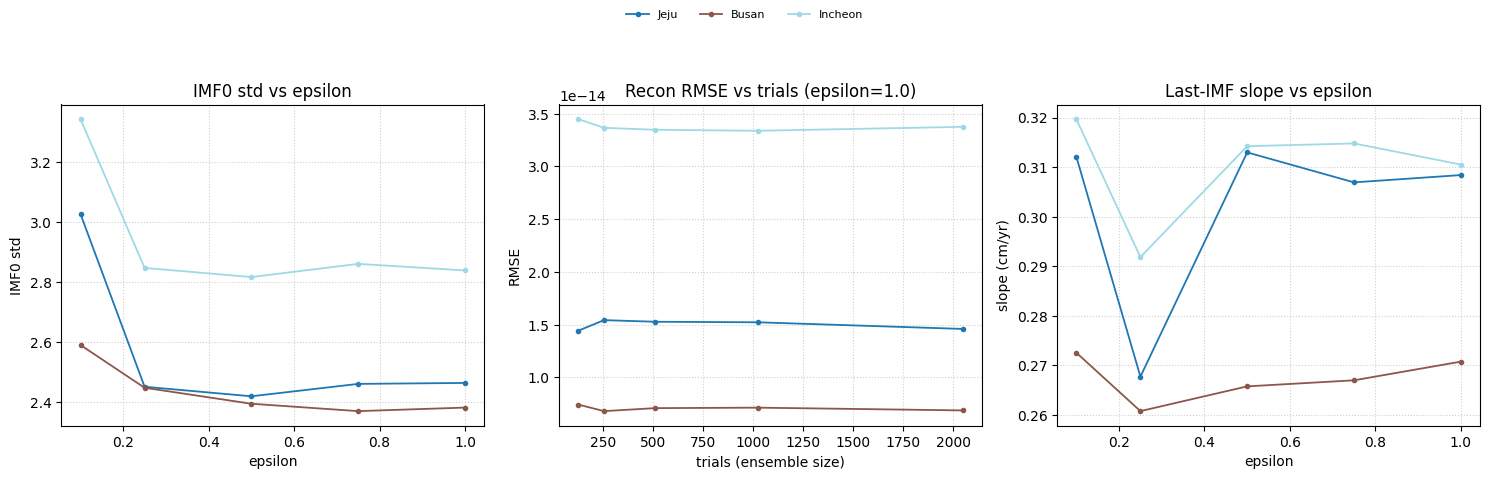

In [22]:
# Build 1x3 panel with all stations overlaid
TRIAL_SUMMARY = int(max(trials_list)) if len(trials_list) else 2048
EPS_SUMMARY = 1.0
fig, axes = plt.subplots(1, 3, figsize=(15, 4.8), sharey=False)
ax_left, ax_mid, ax_right = axes
colors = plt.cm.tab20(np.linspace(0, 1, len(all_results)))

# Left: IMF0 std vs epsilon at fixed trials=max
for (station, df), col in zip(all_results.items(), colors):
    d = df[(df['extrema']=='parabol') & (df['trials']==TRIAL_SUMMARY)].sort_values('epsilon')
    if d.empty: continue
    ax_left.plot(d['epsilon'], d['imf0_std'], '-o', ms=3, lw=1.3, label=station, color=col)
ax_left.set_title('IMF0 std vs epsilon')
ax_left.set_xlabel('epsilon')
ax_left.set_ylabel('IMF0 std')
ax_left.grid(True, ls=':', alpha=.6)

# Middle: RMSE recon vs trials at fixed epsilon=1.0
for (station, df), col in zip(all_results.items(), colors):
    d = df[(df['extrema']=='parabol') & (np.isclose(df['epsilon'], EPS_SUMMARY))].sort_values('trials')
    if d.empty: continue
    ax_mid.plot(d['trials'], d['rmse_recon'], '-o', ms=3, lw=1.3, label=station, color=col)
ax_mid.set_title('Recon RMSE vs trials (epsilon=1.0)')
ax_mid.set_xlabel('trials (ensemble size)')
ax_mid.set_ylabel('RMSE')
ax_mid.grid(True, ls=':', alpha=.6)

# Right: Last-IMF slope vs epsilon at fixed trials=max
for (station, df), col in zip(all_results.items(), colors):
    d = df[(df['extrema']=='parabol') & (df['trials']==TRIAL_SUMMARY)].sort_values('epsilon')
    if d.empty: continue
    ax_right.plot(d['epsilon'], d['slope_last_cm_per_yr'], '-o', ms=3, lw=1.3, label=station, color=col)
ax_right.set_title('Last-IMF slope vs epsilon')
ax_right.set_xlabel('epsilon')
ax_right.set_ylabel('slope (cm/yr)')
ax_right.grid(True, ls=':', alpha=.6)

# Shared legend on top
handles, labels = ax_right.get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc='upper center', ncol=min(5, len(labels)), fontsize=8, frameon=False)
# fig.suptitle('CEEMDAN parameter dependency (extrema=parabol) — All stations')
fig.tight_layout(rect=(0,0,1,0.90))
fig.savefig(OUTPUT_DIR / 'SFig_param_summary_allstations_1x3.png', dpi=300, bbox_inches='tight')
fig.savefig(OUTPUT_DIR / 'SFig_param_summary_allstations_1x3.pdf', bbox_inches='tight')
plt.show()


## Summary Figure (1x3 panels)

All selected stations in one row (3 columns), plotting last-IMF slope vs epsilon (extrema=parabol), with lines per trials.

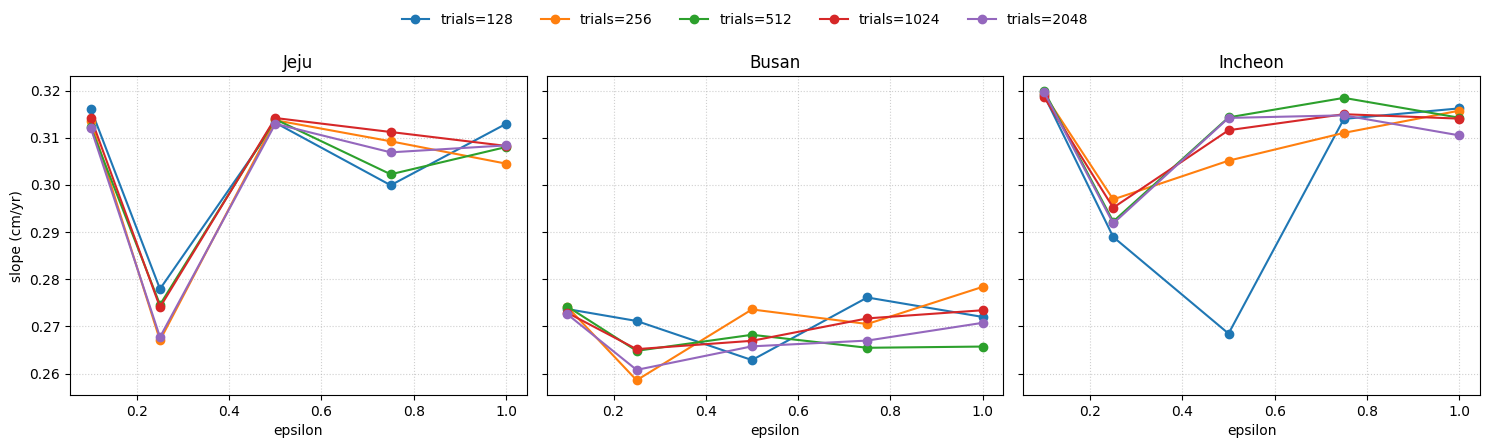

In [23]:
# Build 1x3 panel
sel = list(all_results.keys())
ncols = 3
fig, axes = plt.subplots(1, ncols, figsize=(15, 4.5), sharey=True)
axes = np.atleast_1d(axes)
for i, station in enumerate(sel[:ncols]):
    ax = axes[i]
    df = all_results[station]
    dpar = df[df['extrema']=='parabol']
    for tr in sorted(dpar['trials'].dropna().unique()):
        d2 = dpar[dpar['trials']==tr].sort_values('epsilon')
        if d2.empty: continue
        ax.plot(d2['epsilon'], d2['slope_last_cm_per_yr'], marker='o', label=f'trials={int(tr)}')
    ax.set_title(station)
    ax.grid(True, ls=':', alpha=.6)
    if i == 0: ax.set_ylabel('slope (cm/yr)')
    ax.set_xlabel('epsilon')
# Legend above
handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc='upper center', ncol=min(5, len(labels)), frameon=False)
# fig.suptitle('CEEMDAN parameter dependency — Last IMF slope vs epsilon (extrema=parabol)')
fig.tight_layout(rect=(0,0,1,0.92))
# fig.savefig(OUTPUT_DIR / 'SFig_param_summary_slope_vs_epsilon.png', dpi=300, bbox_inches='tight')
fig.savefig(OUTPUT_DIR / 'SFig_param_summary_slope_vs_epsilon.pdf', bbox_inches='tight')
plt.show()
